### 一.基本思路：类内距离最小化，类间距离最大化
这一节介绍一种监督式的降维方式，线性判别分析（linear discriminant analysis，LDA），它的核心思想是找一条直线使得：类内距离尽可能的小，内间距离尽可能的大，下面画图简单说明一下，并与上一节的PCA做一个区分
![avatar](./source/19_lda1.png)  

如图，红色和绿色分别表示不同类别的样本点，LDA找一条的新的坐标轴将它们分离开，而PCA是一种无监督的降维方式，倾向于将数据投影分散，而不会在乎它们的类别，接下来，我们需要去寻找一个量化指标，与PCA类似地，我们同样可以选择方差，对于二分类的情况，我们可以如此定义   

#### 二分类

两个类别对应的样本集合分别为$X_0,X_1$，中心点分别为$\mu_0,\mu_1$，投影坐标表示为$w$，那么：   

（1）类间方差可以表示为$\left|\left|w^T\mu_0-w^T\mu_1\right|\right|_2^2=w^T(\mu_0-\mu_1)(\mu_0-\mu_1)^Tw$  

（2）类内方差可以表示为$w^T(\Sigma_0+\Sigma_1)w$，这里：   

$$
\Sigma_0=\sum_{x\in X_0}(x-\mu_0)(x-\mu_0)^T\\
\Sigma_1=\sum_{x\in X_1}(x-\mu_1)(x-\mu_1)^T
$$  

为了方便表示，我们定义：   

$$
S_b=(\mu_0-\mu_1)(\mu_0-\mu_1)^T\\
S_w=\Sigma_0+\Sigma_1
$$  

所以，我们的优化目标便有了：   

$$
arg\max_w \frac{w^TS_bw}{w^TS_ww}
$$  

#### 多分类

作为二分类的推广，对于有$j=1,2,..,k$种类别，定义每种类别对应的样本集为$X_j$，样本中心点为$\mu_j$，样本量为$N_j$，整体中心点为$\mu$，我们可以定义   

$$
S_b=\sum_{j=1}^kN_j(\mu_j-\mu)(\mu_j-\mu)^T\\
S_w=\sum_{j=1}^k\sum_{x\in X_j}(x-\mu_j)(x-\mu_j)^T
$$

### 二.广义Rayleigh商求解

接下来就是对于如下表达式的优化问题，其中$A$为对称矩阵（对应$S_b$），$B$为正定对称矩阵（对应$S_w$） ,这便是广义瑞利商  

$$
arg\max_w\frac{w^TAw}{w^TBw}
$$  

对于该问题的求解，我们先考虑简单一点的情况，即瑞利商：   

$$
\frac{w^TAw}{w^Tw}
$$

这个最优解其实在PCA中已经做了推导，瑞利商的最大值即是矩阵$A$特征分解对应的最大特征值，最优解$w$即是最大特征值对应的特征向量（的非零倍数），求解广义RayLeigh商的的思路便是将其变形为一般的瑞利商，即：   

$$
\frac{w^TAw}{w^TBw}\Rightarrow \frac{w^TCw}{w^Tw}
$$  

我们令$\tilde{w}=B^{1/2}w$，这里$B^{1/2}$表示正定矩阵$B$的平方根，即有$B_{ij}^{1/2}=\sqrt{B_{ij}}$，那么有：   

$$
\frac{w^TAw}{w^TBw}=\frac{\tilde{w}^T(B^{-1/2})^TA(B^{-1/2})\tilde{w}}{\tilde{w}^T\tilde{w}}
$$  

所以，我们对矩阵$(B^{-1/2})^TA(B^{-1/2})$进行特征分解，并求得最大特征值对应特征向量便是$\tilde{w}$的最优解$\tilde{w^*}$，然后再根据$w$与$\tilde{w}$的关系求解$w$的最优解  

$$
w^*=B^{-1/2}\tilde{w^*}
$$  

由于$B$正定对称，所以$(B^{-1/2})^T=B^{-1/2}$，其实$w^*$即是$B^{-1}A$最大特征值对应的特征向量，假设$(B^{-1/2})^TA(B^{-1/2})$特征分解后的最大特征值为$\lambda_{max}$，那么有如下推导关系：   

$$
(B^{-1/2})^TA(B^{-1/2})\tilde{w^*}=\lambda_{max}\tilde{w^*}\\  
\Rightarrow B^{-1/2}(B^{-1/2})^TA(B^{-1/2})\tilde{w^*}=\lambda_{max}B^{-1/2}\tilde{w^*}\\
\Rightarrow B^{-1}A(B^{-1/2})\tilde{w^*}=\lambda_{max}B^{-1/2}\tilde{w^*}\\
\Rightarrow B^{-1}Aw^*=\lambda_{max}w^*
$$

### 三.代码实现

根绝上面的推导核心代码其实就很简单了，即首先求出$S_b$和$S_w$，然后再对$S_w^{-1}S_b$做特征分解就可以了，下面构建例子来说明一下

In [1]:
from sklearn.datasets import make_classification
data,target=make_classification(n_samples=50, n_features=2,
                           n_informative=2,n_redundant=0,
                           n_repeated=0, n_classes=2,
                           n_clusters_per_class=1,
                           class_sep=3, random_state=32)

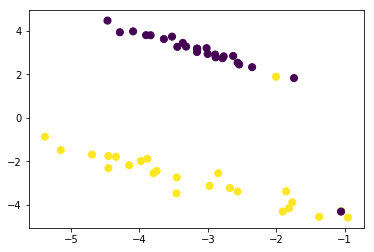

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(data[:, 0], data[:, 1], c=target,s=50)

接下来，构建$S_w,S_b$

In [3]:
import numpy as np
x_mean=np.mean(data,axis=0)#全局中心点

In [4]:
k=np.max(target)+1#类别

In [5]:
dims=len(x_mean)#数据维度

In [6]:
S_b=np.zeros(shape=(dims,dims))
S_w=np.zeros(shape=(dims,dims))

In [7]:
for j in range(0,k):
    idx=np.argwhere(target==j).reshape(-1)
    N_j=len(idx)
    X_j=data[idx]
    x_mean_j=np.mean(X_j,axis=0)
    S_b+=N_j*((x_mean-x_mean_j).reshape(-1,1).dot((x_mean-x_mean_j).reshape(1,-1)))
    S_w+=(X_j-x_mean_j).T.dot(X_j-x_mean_j)

In [8]:
S_b

array([[2.63855365e-02, 3.17920884e+00],
       [3.17920884e+00, 3.83064745e+02]])

In [9]:
S_w

array([[ 54.58456946, -49.38614896],
       [-49.38614896, 110.01224398]])

特征分解

In [10]:
eig_vals,eig_vecs=np.linalg.eig(np.linalg.inv(S_w).dot(S_b))

In [11]:
eig_vals

array([0.        , 5.95245881])

In [12]:
eig_vecs

array([[-0.99996556, -0.67490476],
       [ 0.00829912, -0.73790485]])

In [13]:
#重新排序
sorted_indice=np.argsort(-1*eig_vals)
eig_vals=eig_vals[sorted_indice]
eig_vecs[:]=eig_vecs[:,sorted_indice]

检验新数据分布

In [14]:
new_data=data.dot(eig_vecs)

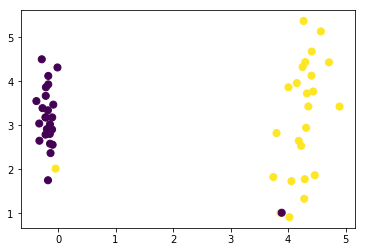

In [15]:
plt.scatter(new_data[:, 0], new_data[:, 1], c=target,s=50)

可以发现只需要第一个坐标轴(k-1)即可将两类数据分割开，接下来对代码做一下整理，放到`ml_models.decomposition.LDA`中